In this second practical session, we explore surface deformation algorithms with two applications : surface parametrization for texture mapping and as-rigid-as possible deformation for non-rigid alignment.

Program for today:
1. Surface Parameterisation

    a. Tutte embedding,

    b. Angle-preserving map with free boundary.
    
2. Surface alignment

    a. Rigid alignment with Iterative Closest Point,

    b. ARAP for non-rigid alignment.


# Environment Setup

We simplified the environment installation. Don't forget to comment after running this command once.

In [ ]:
# !wget -q https://www.lix.polytechnique.fr/~pierson/cours/td2_utils.zip -O td2_utils.zip
# !unzip -qqo td2_utils.zip

In [1]:
from google.colab import drive
import os, urllib.request, zipfile, pathlib, sys

drive.mount('/content/drive')

url = "https://www.lix.polytechnique.fr/~pierson/cours/td2_utils.zip"
dir = pathlib.Path("/content/drive/MyDrive/td2_utils")

if not dir.exists():
    dir.mkdir(parents=True, exist_ok=True)
    path = "/content/td2_utils.zip"
    urllib.request.urlretrieve(url, path)
    with zipfile.ZipFile(path) as z:
        z.extractall(dir)

os.chdir(dir)
sys.path.insert(0, str(dir))
print("cwd:", os.getcwd())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cwd: /content/drive/MyDrive/td2_utils


In [2]:
!pip install -r requirements.txt

  Using cached https://github.com/skoch9/meshplot/archive/0.4.0.tar.gz
  Preparing metadata (setup.py) ... done


In [3]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.sparse
from scipy.sparse import csc_matrix

# THE FOLLOWING COME FROM THE PROVIDED DATA, DO NOT TRY TO PIP INSTALL THEM
import plot_utils as plu
import mesh_utils
from mesh_utils.mesh import TriMesh

### Choose your rendering backend.

Main settings: <b><code style="color:red;">colab</code></b> is if you are in colab, <b><code style="color:red;">server</code></b> if you use a cluster (always true when using colab). The latter needs to have the `xvfb` package installed (automatic in colab). Set up the values correctly!

For those struggling with meshplot, use <b><code style="color:red;">meshplot=False</code></b>

You shouldn't have any problems anymore. However, the interactive windows are replaced by rendering (in different views) of the meshes.

In [4]:
colab = True
server = False
if colab:
    server=True
    from google.colab import output
    output.enable_custom_widget_manager()
if server:
    from xvfbwrapper import Xvfb
    display = Xvfb(width=1280, height=740, colordepth=16)
    display.start()

In [5]:
meshplot = False
if meshplot:
    renderer = plu.MeshPlotRenderer
else:
    renderer = plu.vtkRenderer
vtkrenderer = plu.vtkRenderer
mprenderer = plu.MeshPlotRenderer

# 1 - Surface Parameterisation

Given a triangle mesh with triangle list $T$ ($n_f \times 3$ array of integers) and vertex coordinates $X$ ($n_v \times 3$ array of floats), a parametrization is simply an assignment of planar coordinates $U$ ($n_v \times 2$ array of floats) for each vertex of the mesh. This parametrization will be vizualized by mapping a texture in planar coordinates to 3D coordinates.

## 1.1 Tutte embedding

The most simple way of computing planar coordinates is to fix the boundary of the mesh to predefined positions (in this example a rectangle) and place the inner vertices at the barycenter of their neighbours. More precisely, the planar coordinates $(u_i,v_i)$ of vertex $i$ satisfies the equation:
$$ \sum_{j \in N_i} w_{ij} (u_j - u_i) = 0, \quad \sum_{j \in N_i} w_{ij} (v_j - v_i) = 0, $$
where $w_{ij}$ are the cotan-weights computed in the previous practical session and $N_i$ is the set of vertices linked to $i$ by an edge. Moreover, for a boundary vertex $j$, the coordinates $(u_j,v_j)$ are constrained to the position $(\bar{u}_j,\bar{v}_j)$.

This system of linear equations can be easily rewritten in term of Laplacian matrix $W$ computed in the previous session:
$$
\begin{array}{l}
W u = 0, \text{ and } W v = 0, \\
u_j = \bar{u}_j, \text{ and } v_j = \bar{v}_j \text{ for all boundary vertex $j$.}
\end{array}
$$

Let `id_int` and `id_bnd` be the lists of interior and boundary indices. The boundary coordinates `u[id_bnd]` and `v[id_bnd]` are given by the function ???.  By linearity, the constrained system reads `W[id_int,id_int]*u[id_int] =-W[id_int,id_bnd]*u[id_bnd]`.

1. Build the lists `id_int` and `id_bnd`
2. Solve the constrained system of linear equations
3. Vizualize the texture

###  QUESTION 1 - Border Edges

**Given a set of triangles, compute the list of (unordered) edges which lie at the border**

Note that we use np.unique in the next cell, so don't overcomplicate the problem.

In [ ]:
def get_border_edges(triangles):
    """
    Get the border edges of a mesh. In no particular order

    Parameters
    ----------
    triangles : ndarray of shape (n_triangles, 3)

    Returns
    -------
    border_edges : list of list of length n_border_edges.
                   The border edges of the mesh. Element i contains the two
                     vertices of the i-th border edge.
    """
    border_edges = set()
    for i, j, k in triangles: # iterate through the triangles
        for idx1, idx2 in [(i, j), (j, k), (i, k)]:
          # reorder idx1 and idx2, so that idx1 always takes the smaller value of pairs between ijk
          # for u,v€{i,j,k}, this means (u,v)=(v,u) and allows us to check if edge appears twice, meaning it is interior
          idx1, idx2 = sorted([idx1, idx2])
          if (idx1, idx2) not in border_edges:
            border_edges.add((idx1, idx2))
          else: # if edge is already in set, it is interior
            border_edges.remove((idx1, idx2))
    border_edges = np.array(list(border_edges))
    return border_edges

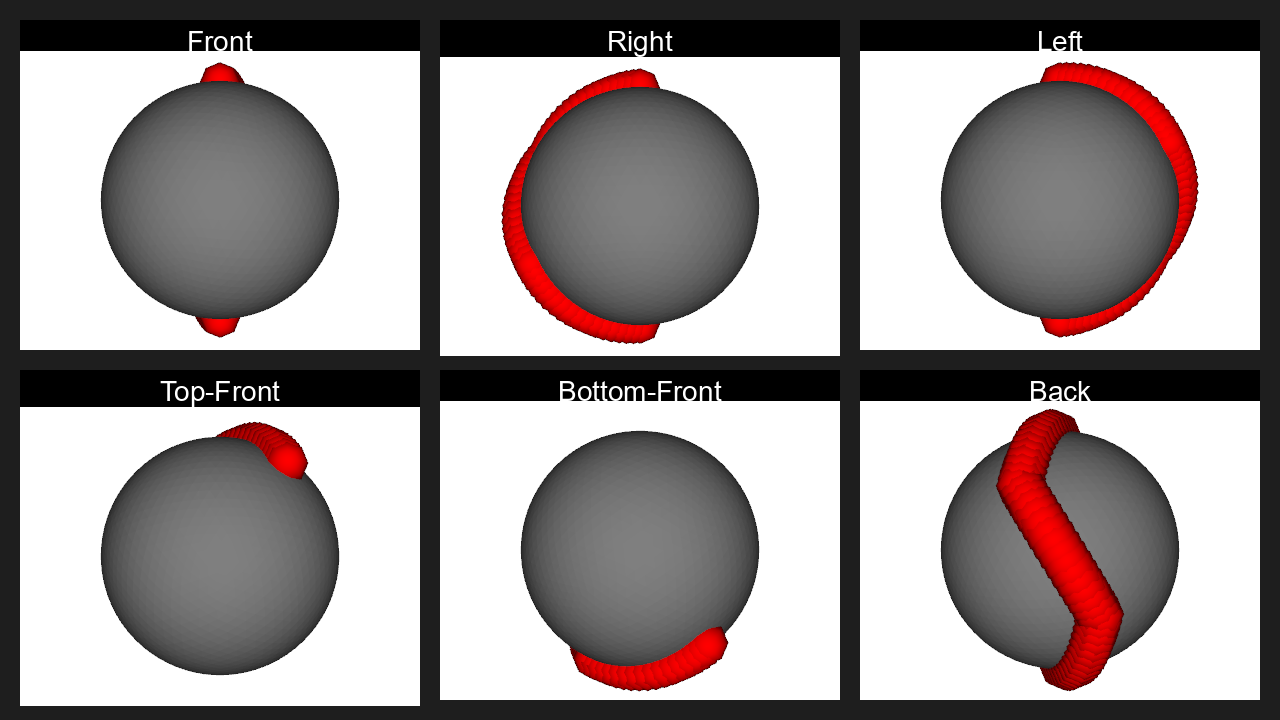

In [ ]:
mesh1 = TriMesh('./data/sphere_cut_uv.obj').process(k=0)

border_edges = get_border_edges(mesh1.faces)
# Visualize the border. It is here just a cut of the sphere
renderer.plot(mesh1, points=np.unique(border_edges))


### Question 2 - Orderd points on a circle

**Write a function to generate evenly spaced points on the circle**
These are going to be the fixed positions of our border vertices

In [ ]:
def get_n_points_on_circle(n_points):
    """
    Builds n_points evenly spaced points on the unit circle.

    Parameters
    ----------
    n_points : int
        Number of points to generate

    Returns
    -------
    points : ndarray of shape (n_points, 2)
        The points on the unit circle
    """
    # YOUR CODE HERE
    points = np.array([[np.cos(2*k*np.pi/n_points), np.sin(2*k*np.pi/n_points)] for k in range(n_points)])

    return points

(-1.1, 1.1, -1.046162167924669, 1.046162167924669)

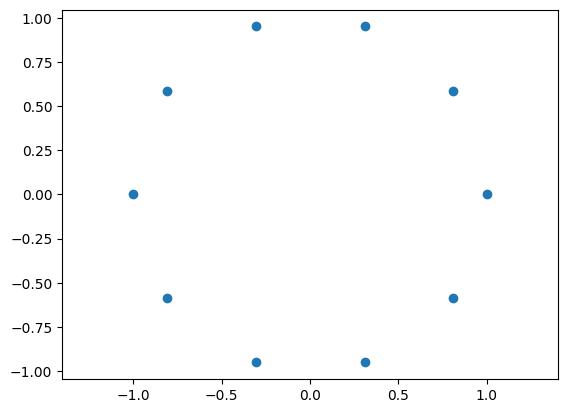

In [ ]:
circle_points = get_n_points_on_circle(10)
plt.figure(dpi=100)
plt.scatter(circle_points[:,0], circle_points[:,1])
plt.axis('equal')

### Question 3 - Solving the Embedding

**Solve for the uv coordinate using ```scipy.sparse.linalg.spsolve```**

Tip: To select ```W[id_int,id_int]``` on a sparse matrix ```W[id_int,id_int]```, use ```W[id_int,:][:,id_int]```.

Because your border points are *ordered*, you will need to use an *ordered* list if border edges. We provide a function below which generates an *ordered* list of border edges using your ```get_border_edges``` function from Question 1.

In [ ]:
def find_next_edge(current_edge, remaining_edges):
        for i, edge in enumerate(remaining_edges):
            if current_edge[1] in edge:
                return i, edge #if edge[0]==current_edge[1] else edge[::-1]
        return None, None

def build_ordered_edges(triangles):
    """
    Compute an ordered list of edges that form a path around the border of the mesh.

    Parameters
    ----------
    triangles : ndarray of shape (n_triangles, 3)

    Returns
    -------
    ordered_edge_list : list of list of length n_border_edges.
                        The border edges of the mesh. Element i contains the two
                        vertices of the i-th border edge.
    """

    border_edges = get_border_edges(triangles)  # (p,2)
    remaining_edges = border_edges.copy() # make a copy of the list since it will be dinamically changed
    ordered_edge_list = []

    # take first edge as the starting edge, remove it from the list of remaining and add it to the ordered list
    current_edge = border_edges[0]
    remaining_edges = np.delete(remaining_edges, 0, axis=0)
    ordered_edge_list.append(current_edge)

    while remaining_edges.size: # stop if all edges were deleted from the list
      index, next_edge = find_next_edge(current_edge, remaining_edges)
      if next_edge is None: # stop if there is no next edge
        break

      next_edge = next_edge if next_edge[0] == current_edge[1] else (next_edge[1], next_edge[0]) # swap vertices for ordering
      ordered_edge_list.append(next_edge)

      current_edge = next_edge # next edge becomes the new current
      remaining_edges = np.delete(remaining_edges, index, axis=0) # remove current edge

    return ordered_edge_list

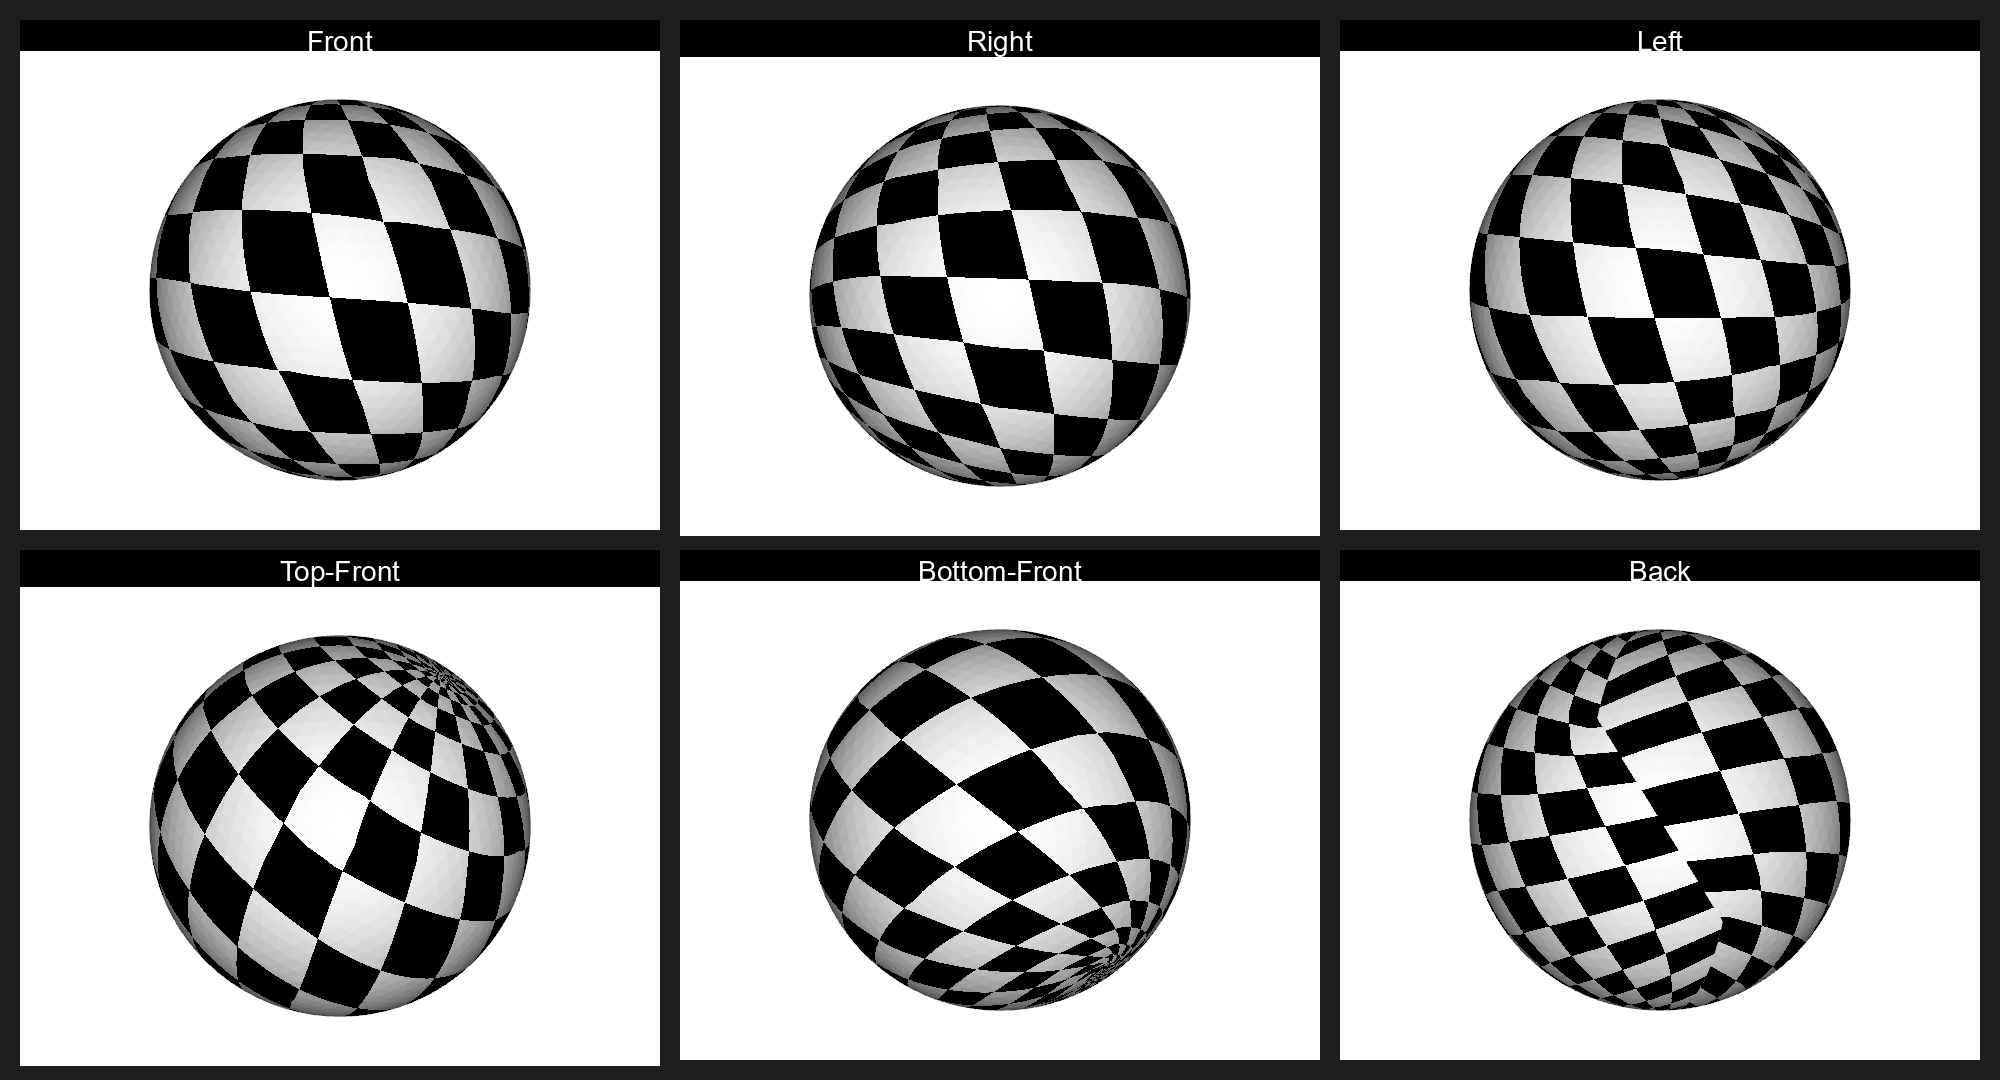

In [ ]:
# Load the mesh and compute the Laplacian
mesh1 = TriMesh('./data/sphere_cut_uv.obj').process(k=0)
uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')[-1]
# Get the list of ordered edges and the Laplacian
ordered_edges = build_ordered_edges(mesh1.faces)
W = mesh1.W

renderer.plot_texture(mesh1.vertices, mesh1.faces, uv_map, wireframe=True)

In [ ]:
 #TODO Compute the embedding u,v using the text above.
 #scipy.sparse.linalg.spsolve
# Tip: To select W[id_int,id_int] on a sparse matrix W[id_int,id_int], use W[id_int,:][:,id_int].

ordered_edges = build_ordered_edges(mesh1.faces)
id_bnd = [edge[0] for edge in ordered_edges] # get the first vertex of every ordered edge
id_int = list(set(range(mesh1.n_vertices)) - set(id_bnd)) # get the interior vertices as the complement of the boundary vertices

Wi_int = W[id_int, :][:, id_int]
Wi_bnd = W[id_int, :][:, id_bnd]
uv_bnd = get_n_points_on_circle(len(id_bnd))
uv_int = scipy.sparse.linalg.spsolve(Wi_int, - Wi_bnd @ uv_bnd) ### (n,2) computed UV coordinates (takes more than 1 line)

uv_total = np.zeros((mesh1.n_vertices, 2)) ### (n,2) computed UV coordinates (takes more than 1 line)
uv_total[id_int] = uv_int
uv_total[id_bnd] = uv_bnd

flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_total

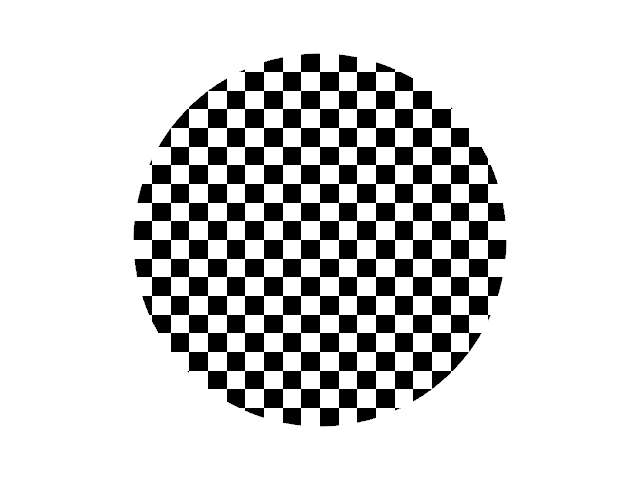

In [ ]:
# Visualize the results
# Flattened coordinates with regular grid
renderer.plot_texture(flat_coords, mesh1.faces, uv_total, wireframe=False, multiple_sides=False)

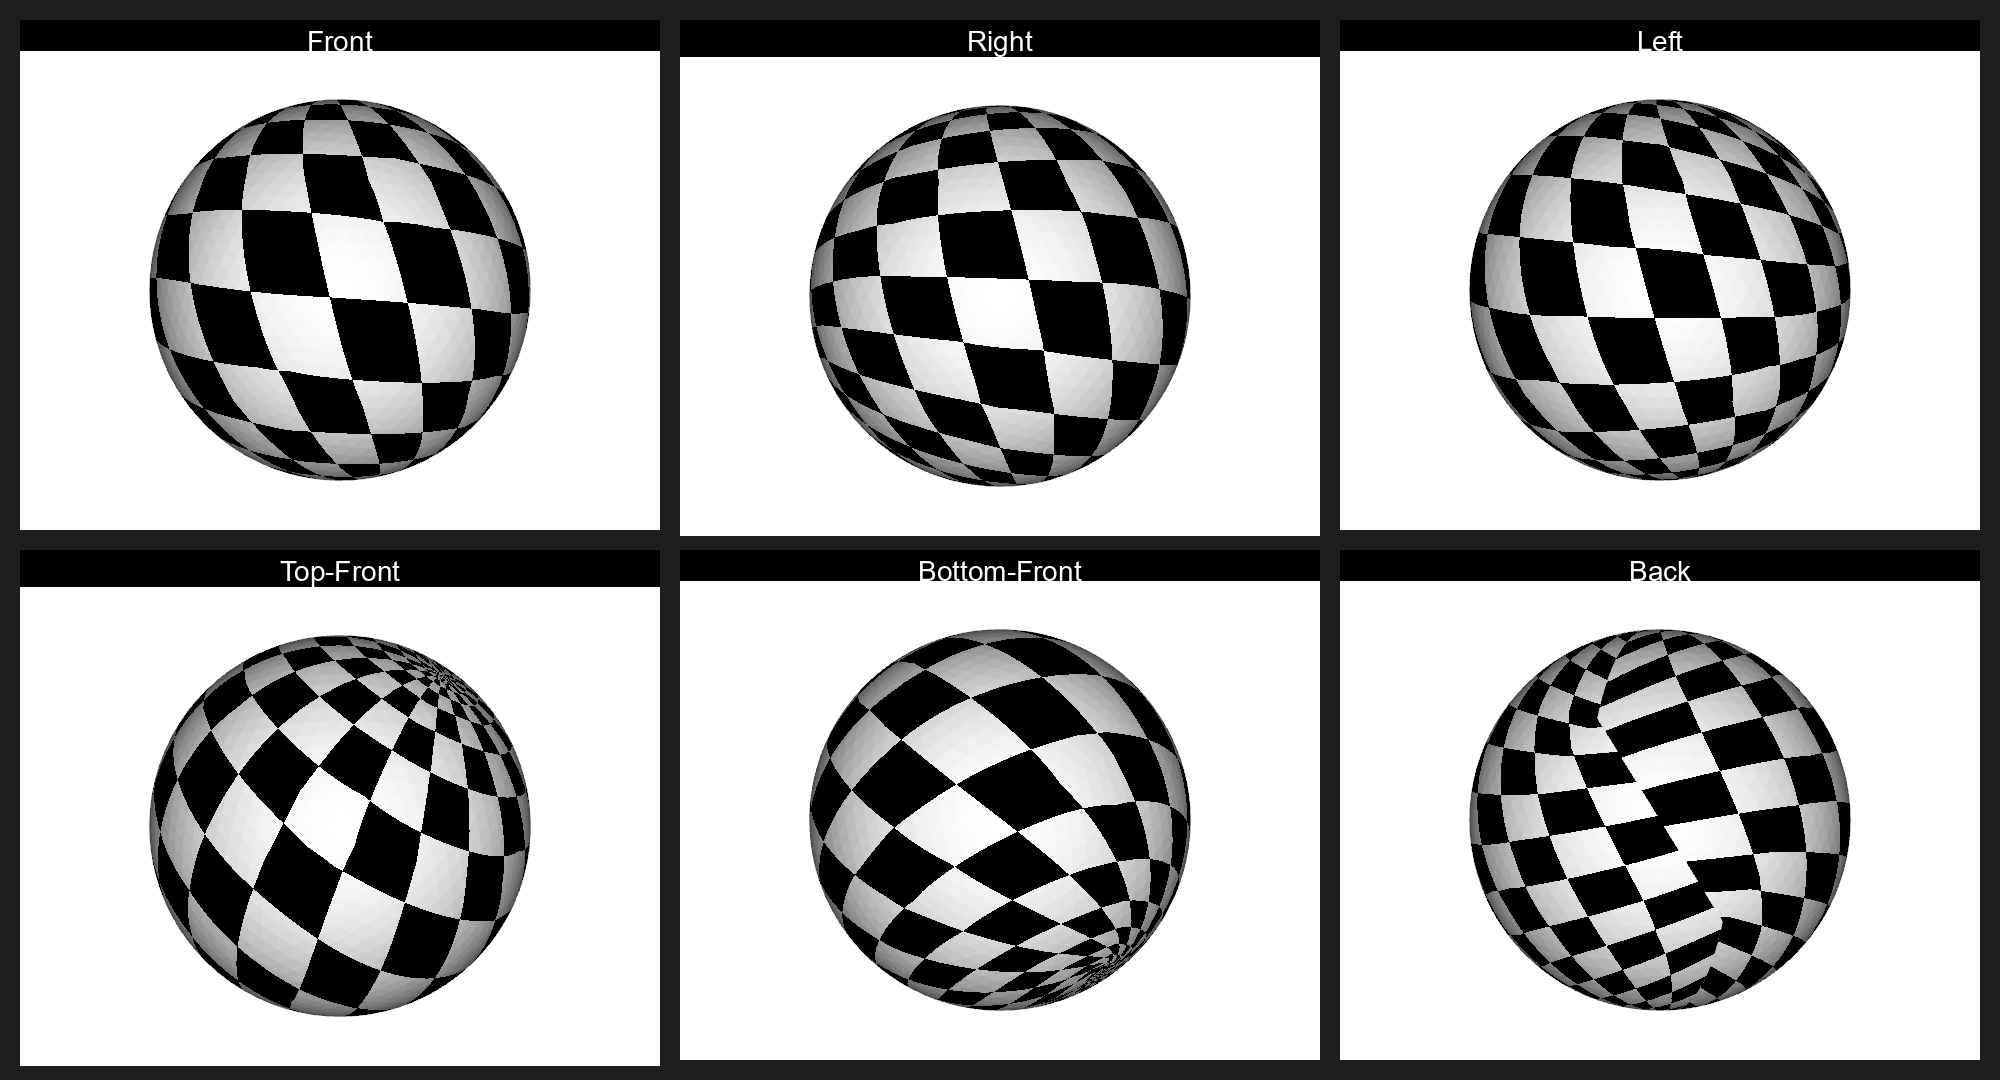

In [ ]:
# We can take the regular grid back to the sphere
renderer.plot_texture(mesh1.vertices, mesh1.faces, uv_map, wireframe=True)

# Or take the Texture of the sphere to the flat world
# renderer.plot_texture(flat_coords, mesh1.faces, uv_total, wireframe=True)

Let's now visualize how it would render on the Earth

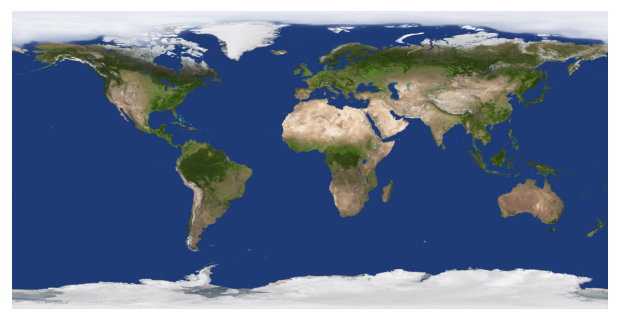

In [ ]:
image = plt.imread('data/earth_daymap.jpg')
plt.figure(dpi=120)
plt.imshow(image)
plt.axis('off');

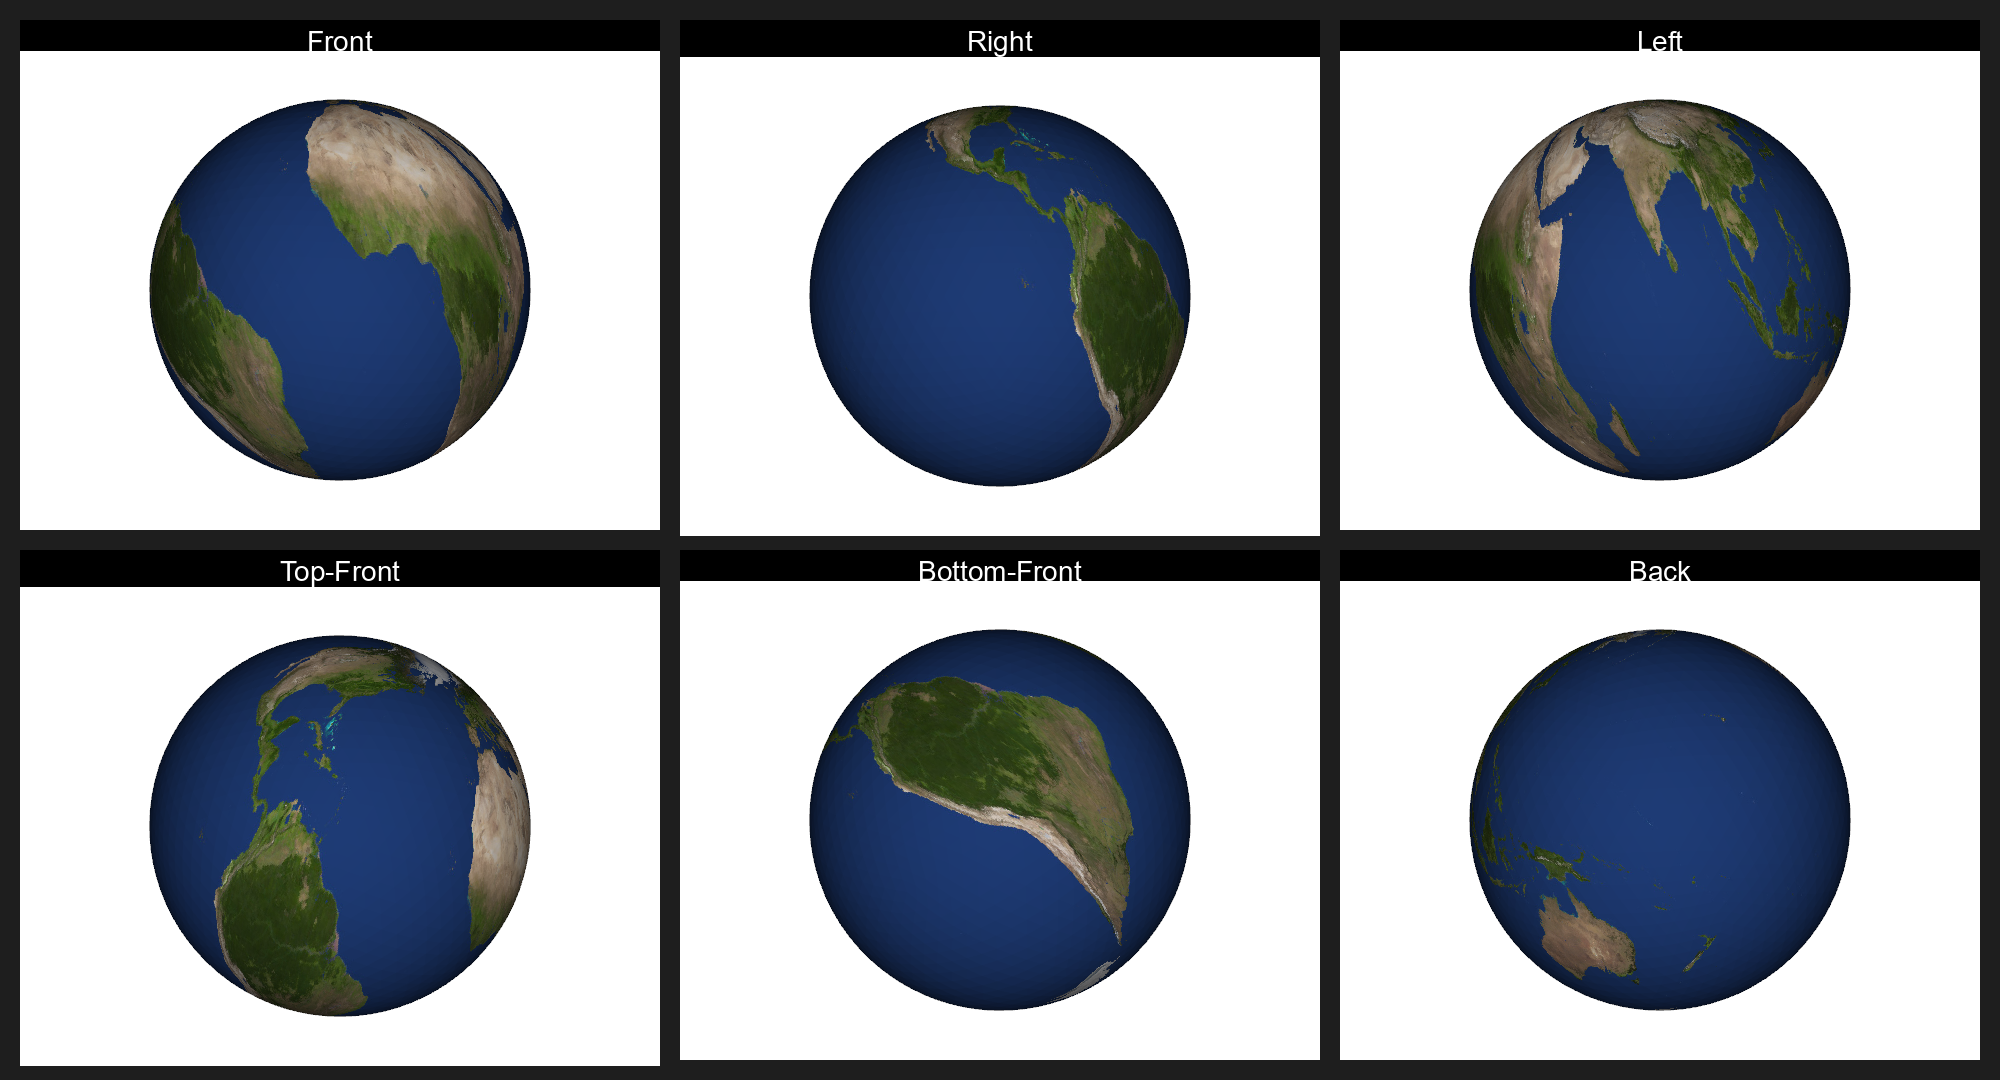

In [ ]:
vtkrenderer.plot_texture(mesh1.vertices, mesh1.faces, uv_map, texture_img="data/earth_daymap.jpg", wireframe=False)

### If you want to visualize it better, save it and load in Meshlab.

In [ ]:
os.makedirs('results', exist_ok=True)
shutil.copyfile('data/earth_daymap.jpg', 'results/earth_daymap.jpg')


# THIS EXPORTS A .OBJ FILE WITH TEXTURE AND MATERIAL INFORMATION. DOWNLOAD AND OPEN WITH MESHLAB
TriMesh(flat_coords, mesh1.faces).export_texture('results/tutte_earth.obj', uv_map, texture_im='earth_daymap.jpg')

## 1.2 Least Square Conformal Map

Conformal maps are special type of parametrization which preserves angles and circles. On a smooth surface, they are characterized by the relationship between the gradient of the coordinate $u$ and the coordinate $v$
$$ \nabla u = n \times \nabla v $$
where $n$ is the surface normal. On a triangle mesh, the coordinates $(u,v)$ are computed using a linear least-squares problem
$$ \min_{u,v} \sum_{t \in T} A_t |\nabla u - n \times \nabla v|^2 \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
where $A_t$ is the area of triangle $t$. As explained in the course, the objective function can be written in term of the Laplacian matrix $W$. This leads to the smallest eigenvalue problem
$$ \min_{u,v} \begin{pmatrix} u \\ v \end{pmatrix}^\top \begin{pmatrix} W & -M \\ -M^\top & W \end{pmatrix} \begin{pmatrix} u & v \end{pmatrix} \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
The sparse matrix $M$ of size $n_v \times n_v$ is given by
$$ M_{ij} = \begin{array}{ll}
0 & \text{if $i$ or $j$ is an interior vertex } \\
1/2 & \text{if $i$ to $j$ is a positive edge of the boundary triangle} \\
-1/2 & \text{if $i$ to $j$ is a negative edge of the boundary triangle}
\end{array} $$

Positive edges are edges that appear when going around a face in the order provided in the file. Negative edges are when going the opposite direction.

*Tips:* To assemble this matrix simply accumulate $\pm\frac{1}{2}$ values for all triangles using the triangle list using the formula above. Since interior edges appear twice in opposite direction in the mesh, their coefficient will vanish for them, and only values for border edges will remin


1. Build the sparse matrix `M`
2. Compute the LSCM parametrization using `scipy.sparse.linalg.eigs`
3. Extract the boundary coordinate of the parametrization and use them to compute a Tutte embedding

### Question 4 - Build M

In [ ]:
def build_M(faces):
    """
    Build the M matrix above with values only at border edges.
    M can be build by adding the formula for M_ij for each edge of each face on the mesh.
    Coefficients at interior edges will vanish because they appear twice with opposite signs.

    Parameters
    ----------
    faces : ndarray of shape (n_faces, 3)

    Returns
    -------
    M : scipy.sparse.csr_matrix of shape (n_vertices, n_vertices)
    """
    n_faces = faces.shape[0]
    n_vertices = np.max(faces) + 1 # number of vertices is equal to maximum index of vertices + 1 since the indices start from 0
    value = 1/2

    # construct csr matrix so that interior edges value sum to 0 and boundary edges are assigned with +-0.5
    list_I, list_J, list_V = [], [], []
    for idx_tup, (idx_1, idx_2) in enumerate([(1, 2), (2, 0), (0, 1)]):
        list_I += [faces[:, idx_1], faces[:, idx_2]]
        list_J += [faces[:, idx_2], faces[:, idx_1]]
        list_V += [np.full(n_faces, value), np.full(n_faces, -value)]

    I = np.concatenate(list_I, axis=0)
    J = np.concatenate(list_J, axis=0)
    V = np.concatenate(list_V, axis=0)

    M = scipy.sparse.csc_matrix((V, (I, J)), shape=(n_vertices, n_vertices)).tocsr() # convert to csr since expected output is csr matrix
    M.eliminate_zeros() # leave only boundary edges
    return M

### Question 5 - Solve the system

Use scipy [bmat function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bmat.html) to build sparse matrices from blocks.
Use scipy

Try with the two meshes (diablo doesn't have uv map)

In [ ]:
#mesh1 = TriMesh("./data/diablo_cut2.obj").process(k=0)
mesh1 = TriMesh("./data/sphere_cut_uv.obj").process(k=0)
uv_map = v,f,uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')
W = mesh1.W

In [ ]:
M = build_M(mesh1.faces)

system_matrix = scipy.sparse.bmat([[W, -M],[-M.T, W]]) #TODO#TODO

res_eigenvalues, res_eigenvectors = scipy.sparse.linalg.eigsh(system_matrix, k=3, which='LM', sigma=-0.001)

# Only take the real part

# Check that first 2 eigenvalues are 0
print(res_eigenvalues)

[-1.29020059e-16 -1.17961196e-16  1.32033361e-05]


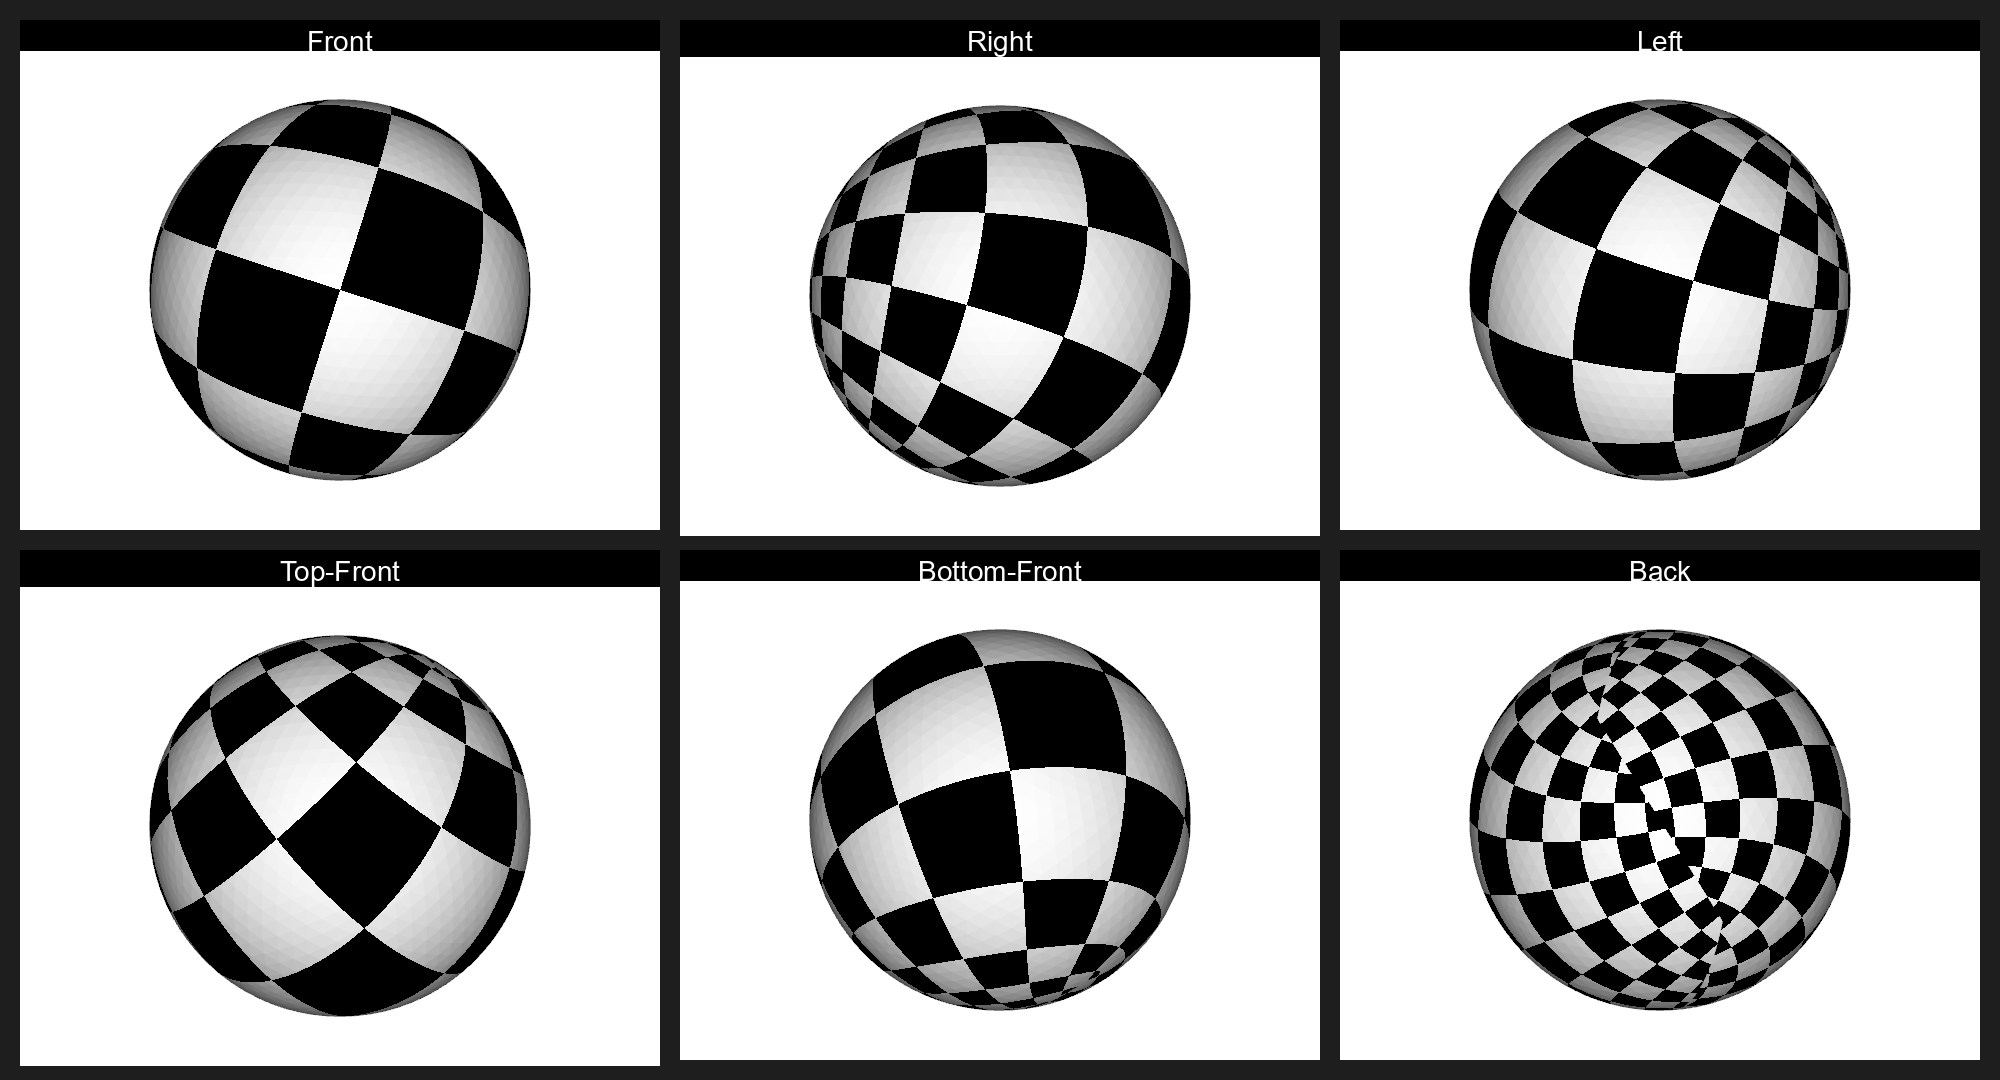

In [ ]:
uv_coords = res_eigenvectors[:,2].reshape((mesh1.n_vertices,2), order='F')

renderer.plot_texture(mesh1.vertices, mesh1.faces, uv_coords)

#plu.plot_texture(flat_coords, mesh1.faces, flat_coords)


# For the Sphere
#plu.plot_texture(flat_coords, mesh1.faces, uv_map, wireframe=True)

you can again visualize with the earth map on the sphere

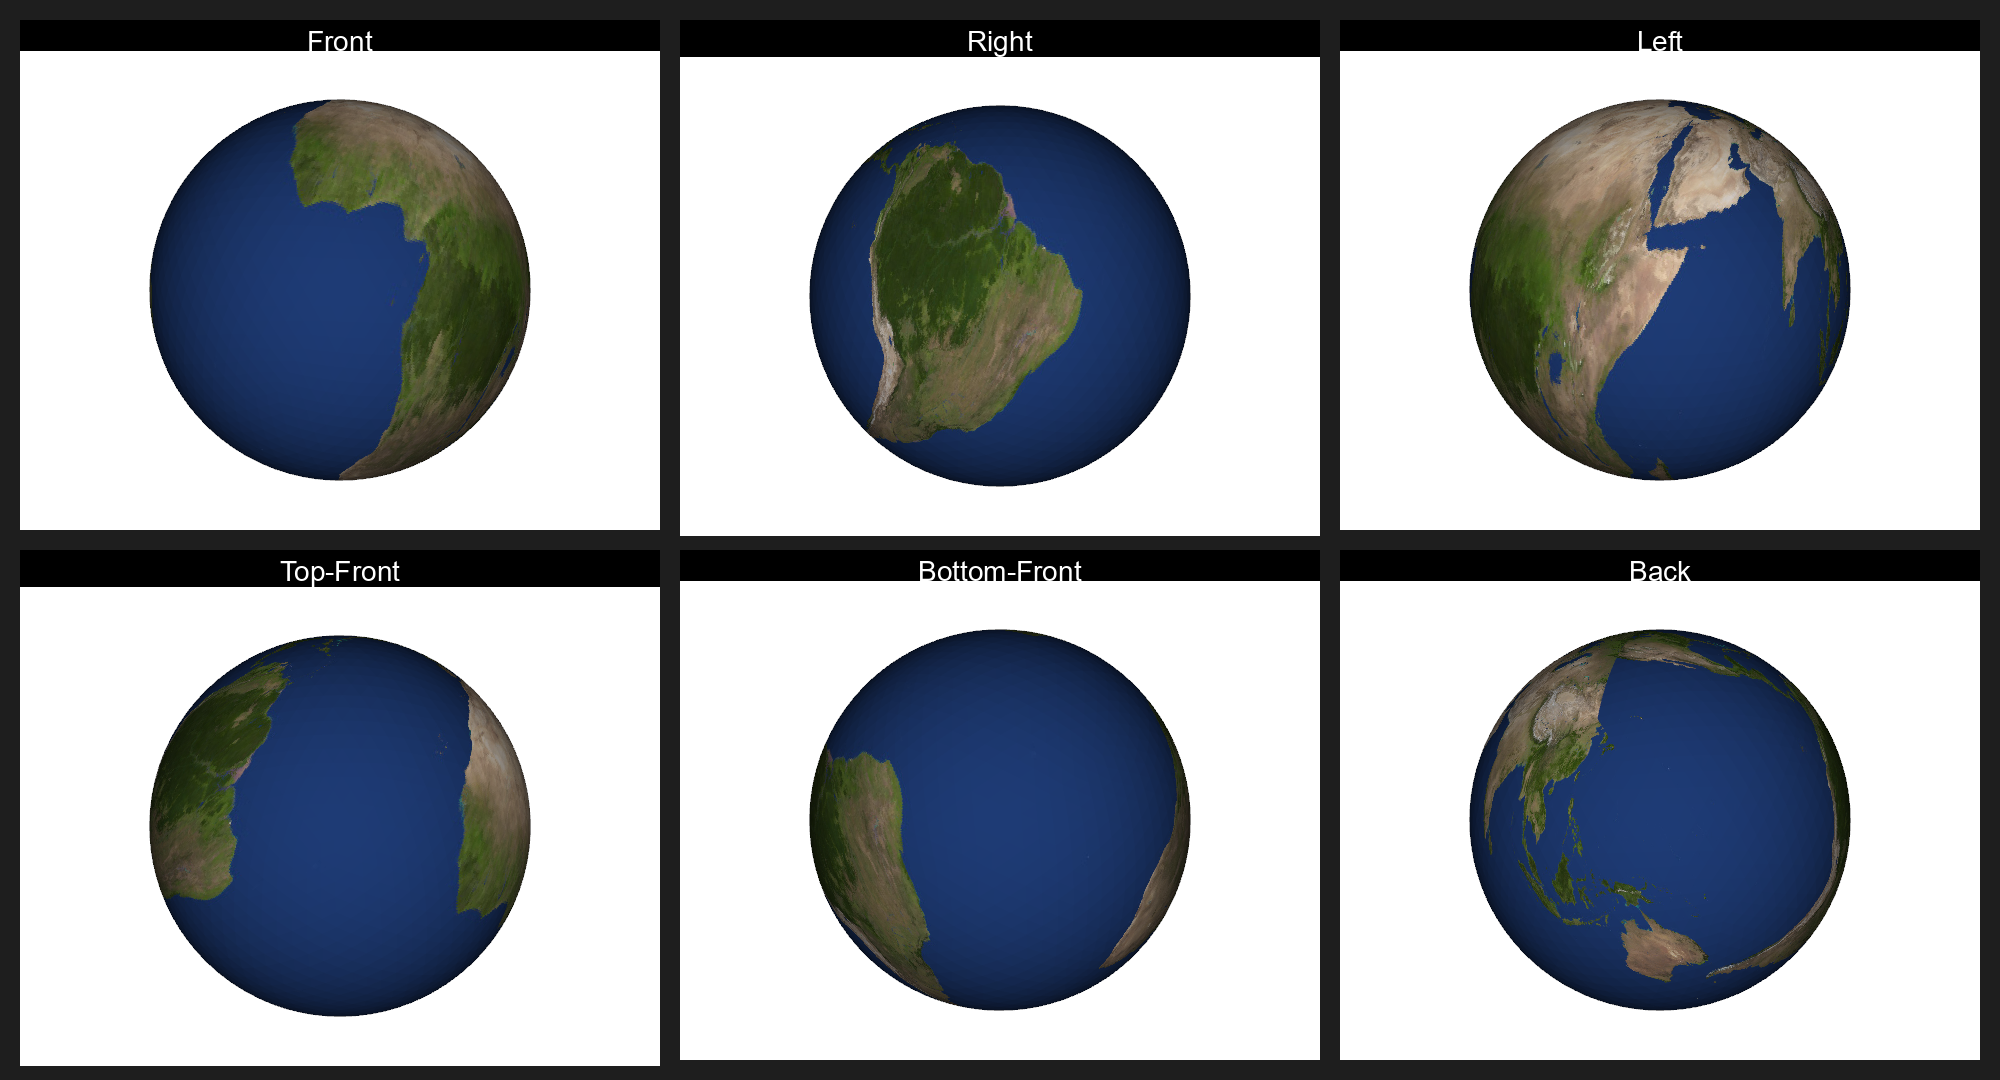

In [ ]:
vtkrenderer.plot_texture(mesh1.vertices, mesh1.faces, uv_coords, texture_img="data/earth_daymap.jpg", wireframe=False)

In [ ]:
flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_total
TriMesh(flat_coords, mesh1.faces).export_texture('results/lscm_earth.obj', uv_coords, texture_im='earth_daymap.jpg')

###  Question 6 - Extract the Border and compute the tutte embedding on the same border (with ordering)

In [ ]:
id_bnd = [edg[0] for edg in ordered_edges]
id_int = list(set(range(mesh1.n_vertices)) - set(id_bnd))

Wi_int = W[id_int, :][:, id_int]
Wi_bnd = W[id_int, :][:, id_bnd]
uv_bnd = uv_coords[id_bnd]
uv_int = scipy.sparse.linalg.spsolve(Wi_int, - Wi_bnd @ uv_bnd)

uv_tutte_2 = np.zeros((mesh1.n_vertices, 2))
uv_tutte_2[id_int] = uv_int
uv_tutte_2[id_bnd] = uv_bnd

flat_coords = np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_tutte_2
print(np.linalg.norm(uv_tutte_2 - uv_coords))
u_border = uv_bnd

0.0007723369868302029


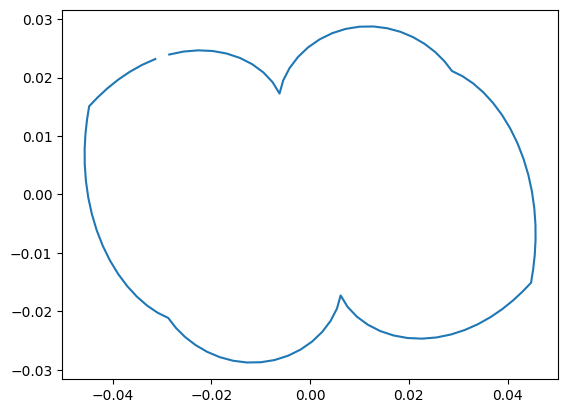

In [ ]:
plt.plot(u_border[:, 0], u_border[:, 1]) # Just a check: we plot to verify that the border is continuous

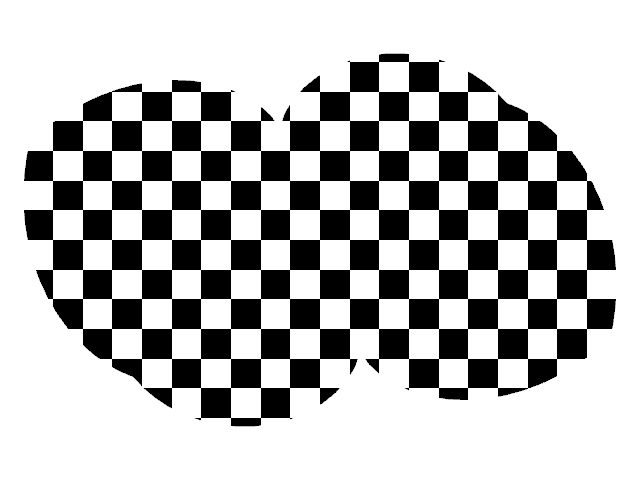

In [ ]:
renderer.plot_texture(flat_coords, mesh1.faces, uv_tutte_2, wireframe=True, multiple_sides=False)

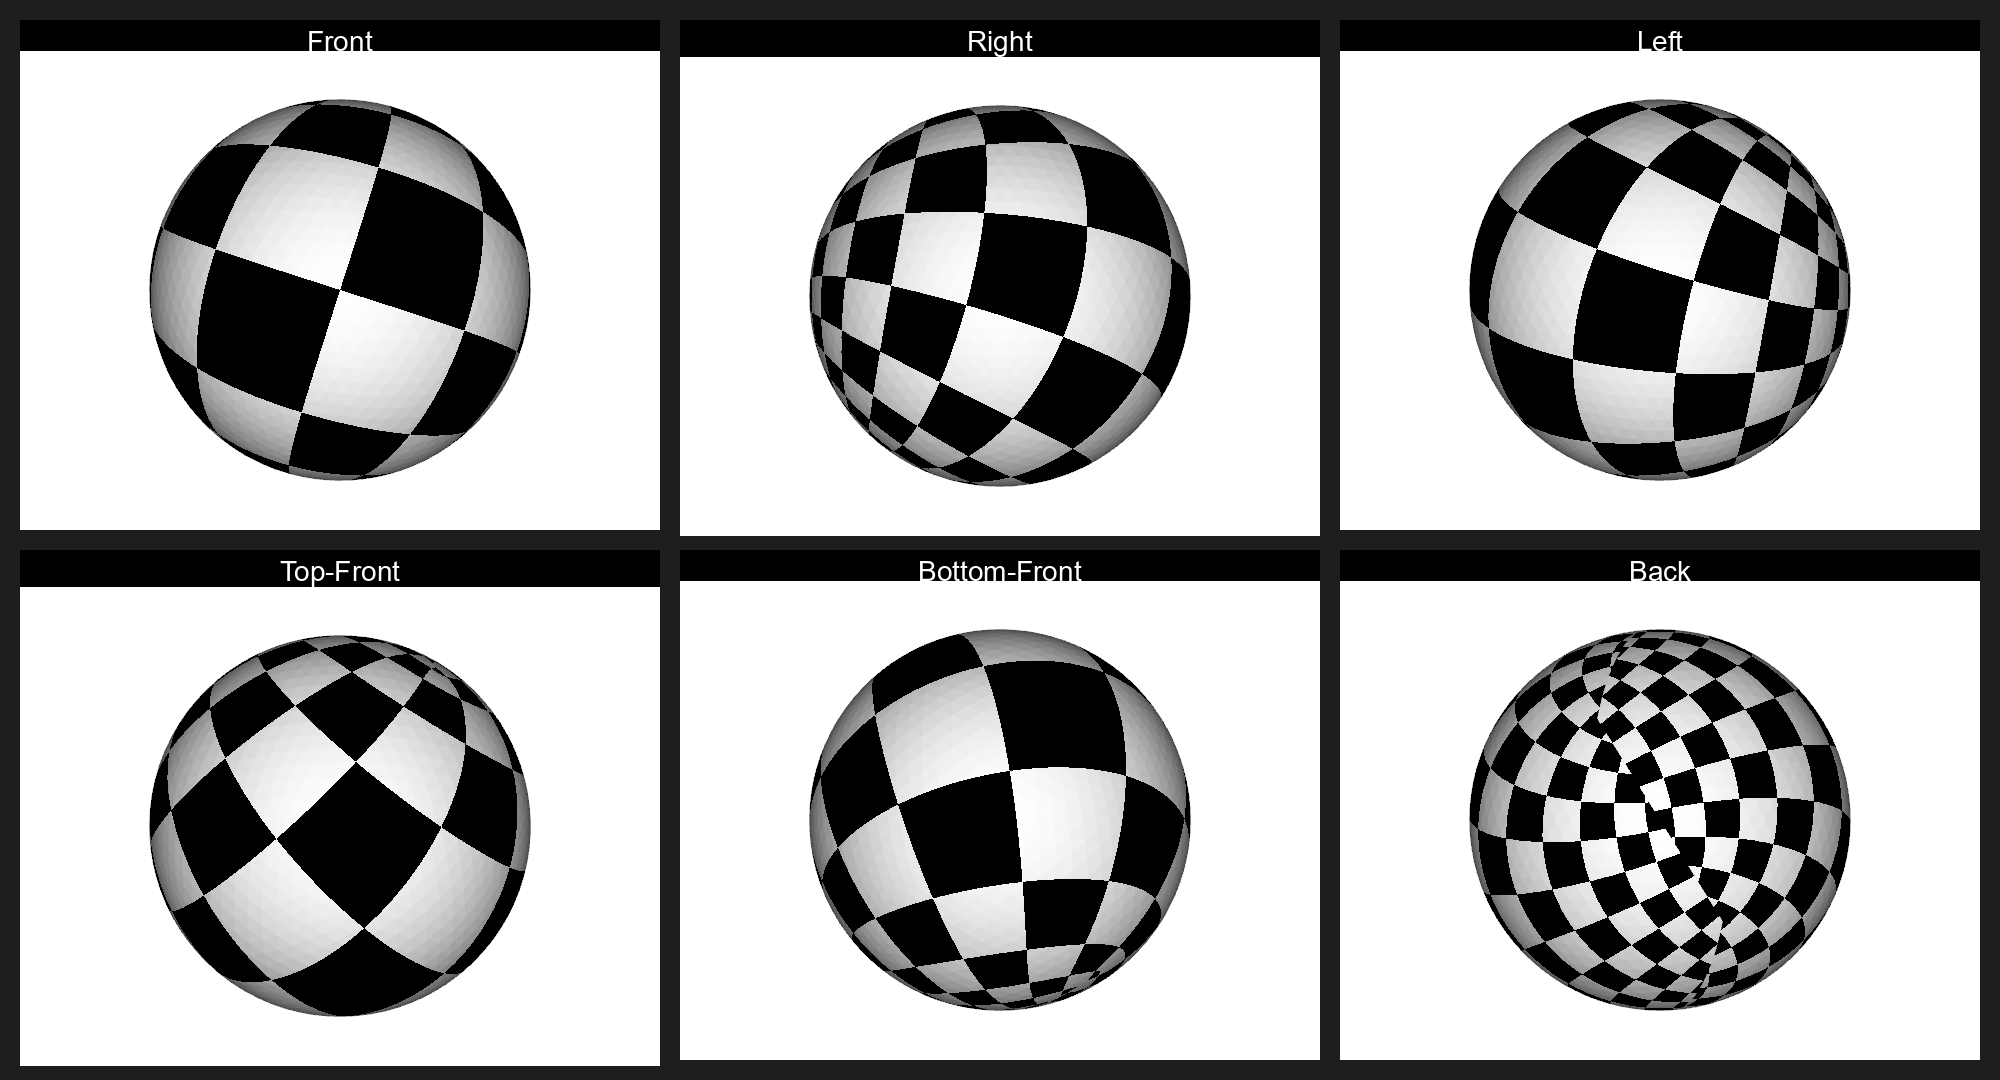

In [ ]:
vtkrenderer.plot_texture(mesh1.vertices, mesh1.faces, uv_tutte_2, wireframe=True)

# 2 Surface Alignment

## 2.1 Iterative Closest Point

The goal of this algorithm is to align two point clouds $X = \{ x_i \}$ and $Y = \{ y_i \}$ using only rigid transformations -- translation and rotation. It is standard algorithm to align 3D scans taken from different viewpoints. The most basic implementation iterates between three steps until convergence:

1. For each point of $X$ compute the closest point in the set $Y$. This assignment is given by the table $p$
$$ p_i = \arg\min_{j} \|x_i - y_j\|^2 .$$
This can be done efficiently with a knn-search.

2. Find the translation that best align the point cloud given the assignment $p$
$$ \min_{t \in \mathbb{R}^3} \sum_i \|x_i + t - y_{p_i}\|^2 .$$
This problem can be solved exactly with the formula $t = \frac{1}{|X|}\sum_i y_i - x_i$.

3. Compute the rotation aligning the point cloud after translation:
$$ \min_{R} \sum_i \|Rx_i + t - y_{p_i}\|^2 .$$
This is an [orthogonal Procrustes problem](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem) and can be solved efficiently using a Singular Value Decomposition ([SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)). Let the matrix $A = \sum_i (t-y_{p_i})x_i^\top$ be decomposed as $A = U S V^\top$ where $U,V$ are unitary matrices and $S$ a diagonal matrix. The optimal rotation is given by $R = U D V^\top$ with $D$ a diagonal matrix with $+1$ on the diagonal corresponding to the two largest singular values and $\pm 1$ on the smallest singular value. The sign is chosen so that $\det R = 1$.

4. Update the position of $X$: $x_i \leftarrow Rx_i+t$


**To do:**
1. Implement the steps
2. Align the Armadilo

### Question 7 - Compute Nearest Neighbor

To speed up computation, use `scipy.spatial.cKDTree`.

In [17]:
# used code for KNN from TD1
from scipy.spatial import cKDTree

class KNNSearch(object):
    DTYPE = np.float32
    NJOBS = 4

    def __init__(self, data):
        self.data = np.asarray(data, dtype=self.DTYPE)
        self.kdtree = cKDTree(self.data)

    def query(self, kpts, k, return_dists=False):
        kpts = np.asarray(kpts, dtype=self.DTYPE)
        nndists, nnindices = self.kdtree.query(kpts, k=k, workers=self.NJOBS)
        if return_dists:
            return nnindices, nndists
        else:
            return nnindices

    def query_ball(self, kpt, radius):
        kpt = np.asarray(kpt, dtype=self.DTYPE)
        assert kpt.ndim == 1
        nnindices = self.kdtree.query_ball_point(kpt, radius, n_jobs=self.NJOBS)
        return nnindices

def compute_nearest_neighbor(X, Y):
    """
    Compute the nearest neighbor in Y for each point in X

    Parameters:
    -----------
    X : (n, d) array of points
    Y : (m, d) array of points

    Returns:
    --------
    nearst_neighbor : (n,) array of indices of the nearest neighbor in Y for X
    """
    # TODO DO NOT USE LOOPS
    querier = KNNSearch(Y)
    nn_indices, nndists = querier.query(X, 1, return_dists=True) # find indices in Y for NN of X and distance for each
    return nn_indices, nndists

### Question 8 - Compute optimal rotations and translation

In [ ]:
def compute_rigid_transform(X_source, X_target):
    """
    Compute the optimal rotation matrix and translation that aligns two point clouds of the same size X_source and X_target.
    This rotation should be applied to X_source.

    Parameters:
    -----------
    X_source : (n, d) array of points
    Y_target : (n, d) array of points

    Returns:
    --------
    R : (d, d) rotation matrix
    t : (d,) translation vector
    """
    # TODO
    t = np.mean(X_target - X_source, axis=0)

    A = (X_target - t).T @ X_source
    U, S, Vt = np.linalg.svd(A)

    D = np.diag([1, 1, np.sign(np.linalg.det(U @ Vt))]) # change the bottom-right value so det(R)=1
    R = U @ D @ Vt

    return R, t

### Question 9 - Apply the ICP algorithm
We provide a function to apply a rigid transformation ```R,t``` to a point cloud

In [ ]:
def transform_pointcloud(X,R,t):
    """
    Transform a point cloud X by a rotation matrix R and a translation vector t.

    Parameters:
    -----------
    X : (n, d) array of points
    R : (d, d) rotation matrix
    t : (d,) translation vector

    Returns:
    --------
    X_transformed : (n, d) array of transformed points
    """
    return X @ R.T + t

In [ ]:
def icp_align(X_source, Y_target, n_iter=10):
    """
    Align two point clouds X_source and Y_target using the ICP algorithm.

    Parameters:
    -----------
    X_source : (n, d) array of points
    Y_target : (m, d) array of points
    n_iter   : int - number of iterations of the ICP algorithm

    Returns:
    --------
    X_aligned : (n, d) array of aligned points
    """
    X_aligned = X_source.copy()

    for _ in range(n_iter):
      nn_indices, _ = compute_nearest_neighbor(X_aligned, Y_target)
      R, t = compute_rigid_transform(X_aligned, Y_target[nn_indices])
      X_aligned = transform_pointcloud(X_aligned, R, t)

    return X_aligned

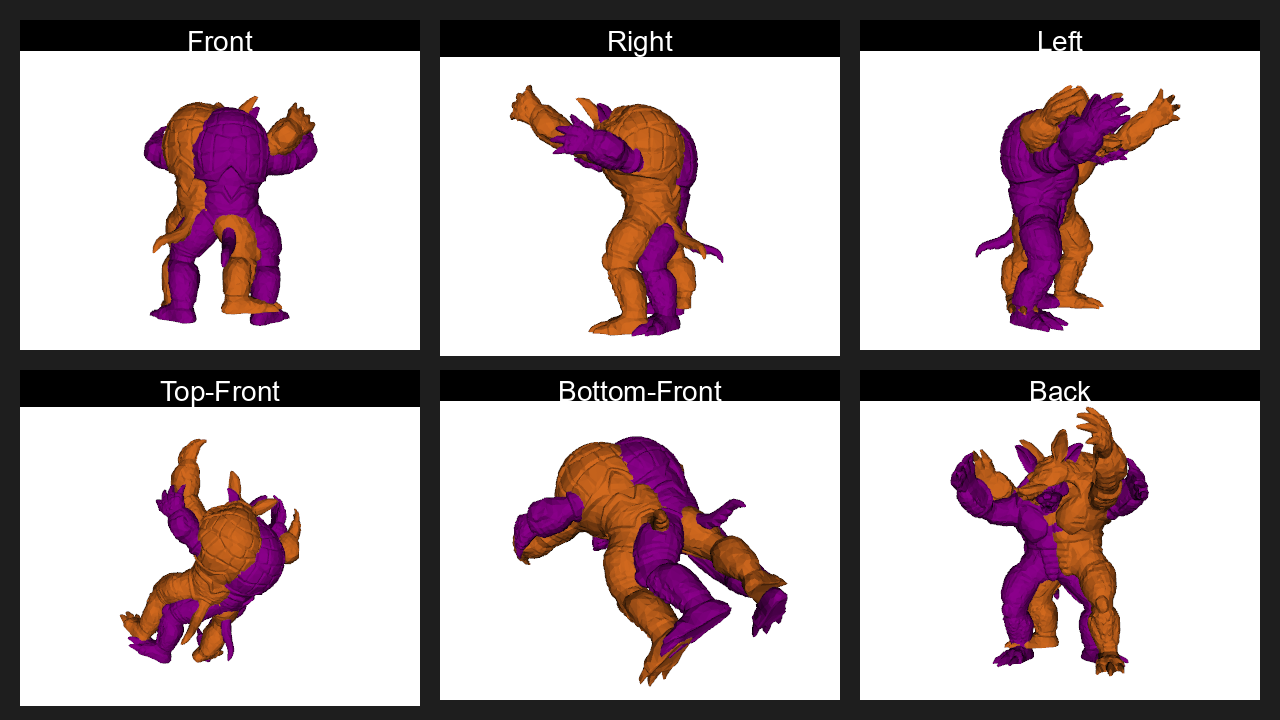

In [ ]:
def plot_superimposed(mesh1, mesh2, color_1=[139, 0, 139], color_2=[210, 105, 30], *args, **kwargs):
    """
    Plot the superposition of the two meshes
    """
    #2B7FFF#2B7FFF
    if meshplot:
        cmap_1 = np.ones(mesh1.vertices.shape)*np.array(color_1)/255.
        cmap_2 = np.ones(mesh2.vertices.shape)*np.array(color_2)/255.
    else:
        cmap_1 = np.ones(mesh1.vertices.shape)*np.array(color_1)
        cmap_2 = np.ones(mesh2.vertices.shape)*np.array(color_2)
    cmap = np.concatenate([cmap_1, cmap_2], axis=0)
    mesh = TriMesh(np.concatenate([mesh1.vertices, mesh2.vertices], axis=0),
                   np.concatenate([mesh1.faces, mesh2.faces+mesh1.n_vertices], axis=0)).process(k=0)
    return renderer.plot(mesh, cmap, *args, **kwargs)

mesh1 = TriMesh("./data/Armadillo_1.off")
mesh2 = TriMesh("./data/Armadillo_2.off")

plot_superimposed(mesh1, mesh2)

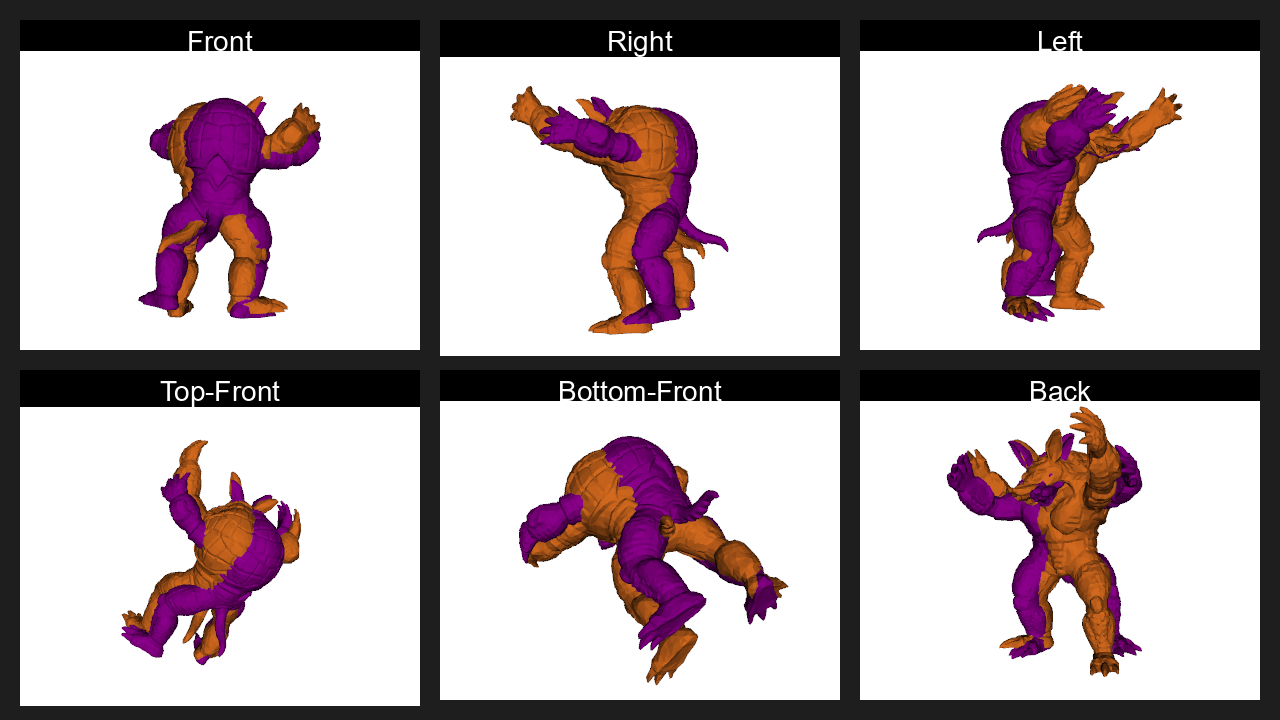

In [ ]:
# VISUALIZE ICP Result
vert1_aligned = icp_align(mesh1.vertices, mesh2.vertices, n_iter=10)

plot_superimposed(TriMesh(vert1_aligned, mesh1.faces), mesh2)

## As-rigid-as possible deformation

This model of  <a href=\"https://igl.ethz.ch/projects/ARAP/arap_web.pdf\">deformation</a> tries to preserves at best the shape features. As explained in the course, given a triangle mesh ($T$: triangle list, $X$: vertex positions) the goal is to find new vertex positions $Y = \\{ y_i\\}$ which are as-close-as possible to a local rotation of the initial position $X$. More precisely, we store a rotation matrix $R_i$ at each vertex $i$ and find the rotations $R$ and position $y$ minimizing\n",

$$ \min_{y,R} \sum_{i} \sum_{j \in N_i} w_{ij} \| y_i - y_j - R_i (x_i - x_j) \|^2, \text{  $y$ subject to position constraint,}$$

with $w_{ij}$ the cotan-weight and $N_i$ the set of vertices adajcent to $i$.
To solve this problem, we iterate between solving for best the position and for rotations.
1. Finding the optimal position $y$ is a constrained Laplacian problem (just like the first question)
$$ W y = b, \quad \text{where } b_i = \sum_{j \in N_i} \frac{w_{ij}}{2} (R_i+R_j) (x_i - x_j) \text{ for each vertex $i$}, $$
and $y$ is constrained at some given vertices.
2. Finding the optimal rotation $R_i$ amounts for solving an orthogonal Procrustes problem for each vertex $i$ where the matrix $B_i = \sum_{j \in N_i} w_{ij} (y_i - y_j) (x_i - x_j)^\top$ is decomposed via a SVD (see step 3 of previous question).

**To do:**
1. Provide functions to compute the initial rotations. This is divided into two subproblems: estimating the covariance, and then computing the rotations using SVD.
2. Fill the function to compute the right side of the optimization
3. Write the optimization loop with the system inside. It consists of alternating between computing b with estimated positions, and solving for new positions.

We provide a function to compute a list of neighbors for each vertex

In [6]:
def get_per_vertex_neighbors(faces):
    """
    Compute per-vertex neighbors from a list of triangles

    Parameters:
    -----------
    faces : (n, 3) array of vertex indices for each triangle

    Returns:
    --------
    neighbors : list of lists of vertex indices
    """

    neighbors = [set() for _ in range(faces.max()+1)]
    for face in faces:
        neighbors[face[0]].add(face[1])
        neighbors[face[0]].add(face[2])

        neighbors[face[1]].add(face[0])
        neighbors[face[1]].add(face[2])

        neighbors[face[2]].add(face[0])
        neighbors[face[2]].add(face[1])

    return [list(n) for n in neighbors]

### Question 10 - Compute the covariance (Matrix B_i)

In [7]:
def get_arap_edge_covariance(x,y, cotan_matrix, per_vertex_neighbors):
    """
    Compute the covariance matrix of the edge between x and y. (Formula B_i)

    Parameters:
    -----------
    x : (n,3) array of coordinates of x
    y : (n, 3) array of coordinates of y
    cotan_matrix : (n,n) cotan matrix of the mesh
    per_vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    covariances : (n, 3, 3) covariance matrices of the edge between x and y
    """
    n = x.shape[0]
    covariances = np.zeros((n, 3, 3))

    for i in range(n):
      for j in per_vertex_neighbors[i]:
        # we use minus instead of plus since cotan_matrix has negative values off the diagonal (-w_ij), while ARAP requires positive (w_ij)
        covariances[i] -= cotan_matrix[i, j] * np.outer((y[i]-y[j]), (x[i]-x[j])) # np.outer computes (y[i]-y[j])(x[i]x[j]).T

    return covariances

### Question 11 - Compute Rotations from Covariance (compute R_i)

In [8]:
def get_rot_from_covariances(covariances):
    """
    Compute optimal rotation matrix from edge covariance matrices, using SVD.

    Parameters:
    -----------
    covariances : (n, 3, 3) covariance matrices for each vertex

    Returns:
    --------
    rots : (n, 3, 3) rotation matrices for each vertex
    """
    U, S, Vt = np.linalg.svd(covariances)
    sign = np.sign(np.linalg.det(U @ Vt)) # determine the sign of det(pre-rotation)
    U[sign < 0, :, -1] *= -1 # if det is negative, flip the last column of U so that det is positive
    rots = U @ Vt

    return rots

### Question 12 - Compute Rotated vertices (vector b_i)

In [9]:
def compute_ARAP_rotated_vert(vertices, rotations, cotan_matrix, per_vertex_neighbors):
    """
    Compute the right hand term of the ARAP linear system (formula b_i)

    Parameters:
    -----------
    vertices : (n, 3) array of vertices
    rotations : (n, 3, 3) array of rotation matrices
    cotan_matrix : (n,n) cotan matrix of the mesh
    per_vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    b : (n, 3) right hand term of the ARAP linear system
    """
    n = vertices.shape[0]
    b = np.zeros((n, 3))

    for i in range(n):
      for j in per_vertex_neighbors[i]:
        # we again use minus, like in the case of covariance
        b[i] -= 0.5 * cotan_matrix[i, j] * (rotations[i]+rotations[j]) @ (vertices[i]-vertices[j])

    return b


### Question 13 - Apply ARAP Deformation.

We first load the mesh and visualize it with the objective landmark deformation.

In [ ]:
mesh3 = TriMesh("data/cactus.off").process(k=0)

# THE ID OF THE LANDMARKS
id_mouv = [1756, 1298, 1663, 118, 637, 1842]
id_lock = id_mouv
# THE EXPECTED POSITIONS OF THE LANDMARKS AFTER OPTIMIZATION
disp = np.array([[0,-0.25,-0.46], [0,-0.4,-0.3], [0,-0.55, -0.], [0, -0.08, -0.05], [0, -0.08, -0.05], [0, 0, 0]])
positions_target = mesh3.vertices[id_lock] + disp

In [ ]:
np.tile(np.arange(len(id_lock)),2)

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5])

(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)


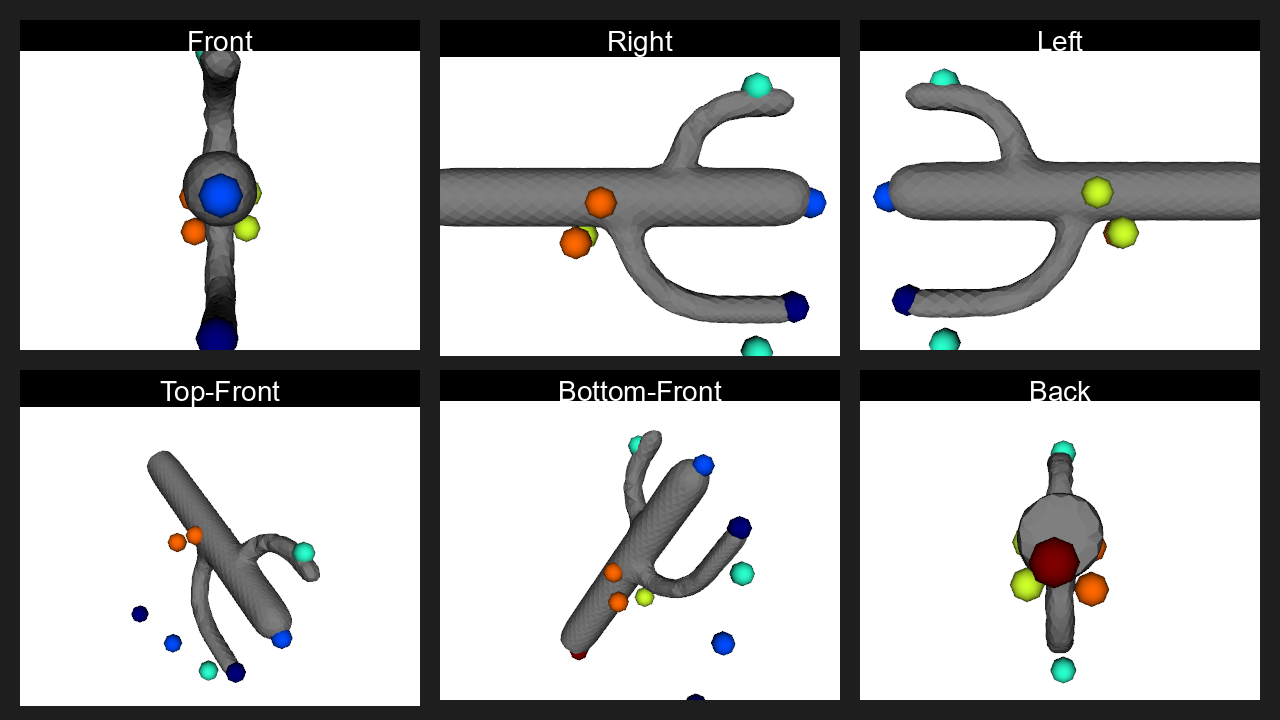

In [ ]:
# VISUALIZE THE LANDMARKS
renderer.plot(mesh3,
         points=np.concatenate([mesh3.vertices[id_lock], positions_target]),
         cmap_p=np.tile(np.arange(len(id_lock)),2),
         colormap='jet')

### ARAP Loop

Write the ARAP loop by filling in the blanks

In [ ]:
vertex_neighbors = get_per_vertex_neighbors(mesh3.faces)
n_arap_loop = 3
W = mesh3.W.copy()
print(W.shape, mesh3.n_vertices)
# Interior vertices
id_in = [i for i in range(mesh3.n_vertices) if i not in id_lock]

# Initial guess for the vertices
init_res = np.zeros_like(mesh3.vertices)
init_res[id_lock] = positions_target
init_res[id_in] = mesh3.vertices[id_in]

for i in range(n_arap_loop):
    # Compute rotation matrices
    covariances = get_arap_edge_covariance(mesh3.vertices, init_res, W, vertex_neighbors)
    rotations = get_rot_from_covariances(covariances)
    b_term = compute_ARAP_rotated_vert(mesh3.vertices, rotations, W, vertex_neighbors)

    # Compute right hand term and left hand term of ARAP SYSTEM
    # Think about the constraint, go back the the text in part 1.1 to see how to build the constrained system
    lhs = W[id_in, :][:, id_in] #TODO left hand side of the system
    rhs = -W[id_in, :][:, id_lock] @ positions_target + b_term[id_in] #TODO right hand side of the system

    res = scipy.sparse.linalg.spsolve(lhs, rhs)

    ## Add the update of your guess
    init_res = np.zeros_like(mesh3.vertices)
    init_res[id_lock] = positions_target
    init_res[id_in] = res

final_res = init_res # final_res is the last iterations' init_res


(1856, 1856) 1856


In [ ]:
last_mesh = TriMesh(final_res, mesh3.faces)

(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)


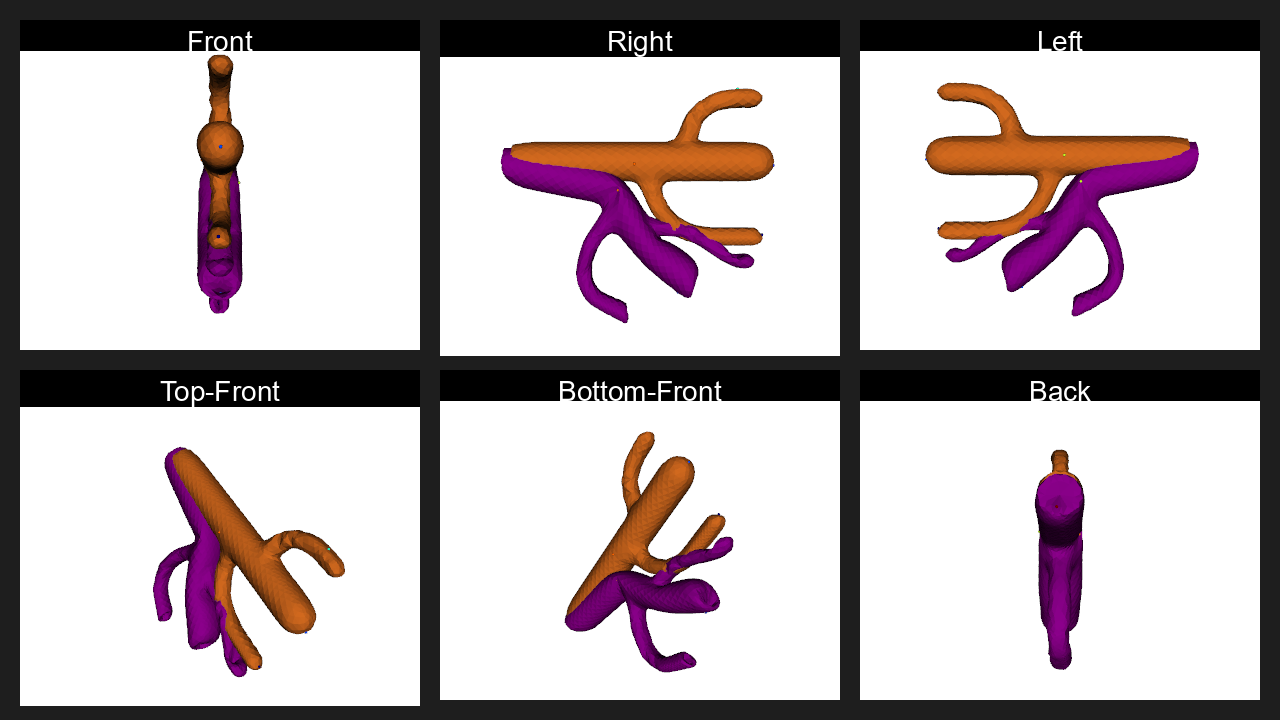

In [ ]:
plot_superimposed(last_mesh, mesh3,
         points=np.concatenate([mesh3.vertices[id_lock], positions_target]),
         cmap_p=np.tile(np.arange(len(id_lock)),2), point_size=0.01,
         colormap='jet')

### Question 15: Write a non-rigid registration algorithm

Now that you have a non-rigid deformation model, make a non-rigid icp function such that it does:

1. Compute approximate spatial nearest neighbor
2. Use this as a guess for ARAP and compute ARAP deformation
3. Updates the approximate spatial guess

Finally, plot the registration. All main functions are ready, it's time to write a bit on your own.

Firstly, we will load Armadillo meshes and compute their W matrix.

In [10]:
mesh11 = TriMesh("./data/Armadillo_1.off").process(k=0)
mesh22 = TriMesh("./data/Armadillo_2.off").process(k=0)

We then extract the ARAP local and global step from the ARAP loop in Question 13.

In [11]:
def arap_local_step(X_source, X_target, W, vertex_neighbors):
  """
    Compute the right hand term of the ARAP linear system (formula b_i)

    Parameters:
    -----------
    X_source : (n, 3) source (reference) vertices
    X_target : (n, 3) current deformed vertices
    W : (n,n) cotan matrix of the mesh
    vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    b_term : (n, 3) right hand term of the ARAP linear system
  """
  covariances = get_arap_edge_covariance(X_source, X_target, W, vertex_neighbors)
  rotations = get_rot_from_covariances(covariances)
  b_term = compute_ARAP_rotated_vert(X_source, rotations, W, vertex_neighbors)

  return b_term

In [12]:
def arap_global_step(W, b_term, id_in, id_lock, positions_target):
   """
    Compute the right hand term of the ARAP linear system (formula b_i)

    Parameters:
    -----------
    W : (n,n) cotan matrix of the mesh
    b_term : (n, 3) right hand term of the ARAP linear system
    id_in : (k,) indices of interior vertices
    id_lock : (l,) indices of locked (constraint) vertices
    positions_target : (l, 3) target positions for locked (id_lock) vertices

    Returns:
    --------
    res : (k, 3) updated positions of interior vertices
   """
   lhs = W[id_in, :][:, id_in]
   rhs = b_term[id_in] - W[id_in, :][:, id_lock] @ positions_target
   res = scipy.sparse.linalg.spsolve(lhs, rhs)

   return res

To obtain the locked and interior vertices, we first find, for every source vertex, its nearest neighbor on the target. Out of those computed distances, we select only the best percentile and treat those indices as locked, since those are considered to be the closest matches. All remaining vertices are considered interior and will later be solved using ARAP.

In [13]:
def find_locked_and_interior_ids(n_vertices, nndists, percentile_to_keep):
  """
    Select locked and interior indices based on the nearest neighbor distances.
    Distances are computed between source and current deformed vertices.
    Locked distances fall under percentile_to_keep percent of lowest distances.
    The remaining vertices are considered interior.

    Parameters:
    -----------
    n_vertices : number of source mesh's vertices
    nndists : (n, ) per vertex nearest neighbor distances
    percentile_to_keep : percentile threshold

    Returns:
    --------
    id_lock : (k,) indices of interior vertices
    id_in : (l,) indices of locked (constraint) vertices
  """
  distance_threshold = np.percentile(nndists, percentile_to_keep) # get the distance value at percentile_to_keep percentile and use it as a threshold
  id_lock = np.where(nndists <= distance_threshold)[0] # collect all indices as locked if their distance is <= then threshold
  id_in = np.setdiff1d(np.arange(n_vertices), id_lock) # collect all indices that are not locked

  return id_lock, id_in

The non-rigid algorithm iteratively finds the nearest neighbors and then estimates a new deformation. This process can be repeated for a specified number of iterations, but it can also be stopped early if the algorithm has converged. Based on this [paper](https://arxiv.org/html/2501.10335), we will use the relative change function between two successive deformations' vertices in order to check for the convergence. We will use the formula $
relative\_change = \frac{\left\| X^{(k)} - X^{(k-1)} \right\|}
       {||X^{(k)}||}
$, where $X^{(k)}$ and $X^{(k-1)}$ are previous and current deformed vertices.

In [14]:
def compute_relative_change(previous_vertices, current_vertices):
  """
    Compute the relative change between the previous and current deformed vertices.

    Parameters:
    -----------
    previous_vertices : (n, 3) previous deformed vertices
    current_vertices : (n, 3) current deformed vertices

    Returns:
    --------
    relative change between two consecutive iterations
  """
  position_change = np.linalg.norm(current_vertices - previous_vertices) # compute the vertices magnitude between two consecutive iterations
  scale = (np.linalg.norm(current_vertices) + 1e-12) # compute the scale of current vertices so the change is relative
  return position_change / scale

We will know merge all of the previous functions together and write the non rigid icp function. We will form two loops, outer and inner. The outer loop recomputes the nearest neighbors and locked vertices. The inner loop performs the ARAP for updating the deformed mesh.

In [25]:
def non_rigid_icp(mesh1, mesh2, outer_iterations=3, inner_iterations=5, percentile_to_keep=30.0, tolerance=8*1e-3):
    """
      Compute non-rigid ICP with ARAP.

      Parameters:
      --------
      mesh1: source mesh
      mesh2: target mesh
      outer_iterations: number of nearest neighbor and locked indices updates
      inner_iterations: number of ARAP loops
      percentile_to_keep: distance percentile threshold
      tolerance: convergence threshold for relative change between two consecutive iterations

      Returns:
      --------
      init_target: (n, 3) final deformed vertices
      id_lock : (l,) indices of locked (constraint) vertices
    """
    X_source = mesh1.vertices
    X_target = mesh2.vertices

    vertex_neighbors = get_per_vertex_neighbors(mesh1.faces)
    W = mesh1.W.copy()
    init_target = X_source.copy() # initial guess for vertices; updated each iteration
    n_vertices = X_source.shape[0]

    count = 0

    for _ in range(outer_iterations):
      # find closest points between current deform and target
      # use them as a guess for locked and interior indices
      nn_indices, nndists = compute_nearest_neighbor(init_target, X_target)
      id_lock, id_in = find_locked_and_interior_ids(n_vertices, nndists, percentile_to_keep)

      positions_target = X_target[nn_indices[id_lock]] # position of locked indices in target
      init_target[id_lock] = positions_target # update the vertices at id_lock to their target matches

      for _ in range(inner_iterations):
        current_target = init_target.copy() # keep previously deformed vertices for convergence check

        # ARAP
        b_term = arap_local_step(X_source, init_target, W, vertex_neighbors)
        res = arap_global_step(W, b_term, id_in, id_lock, positions_target)

        init_target[id_in] = res # update interior vertices based on ARAP result

        relative_change = compute_relative_change(current_target, init_target) # compute the relative change between new and previous deformation
        if relative_change < tolerance: # check for convergence
          print(f"Converged after {count} iterations!")
          return init_target, id_lock

        print(f"After {count}-th iteration, the relative change is {relative_change}")
        count += 1
    return init_target, id_lock

In [26]:
final_target, id_lock = non_rigid_icp(mesh11, mesh22, outer_iterations=3, inner_iterations=5, tolerance=1e-4)

After 0-th iteration, the relative change is 0.01646917139399922
After 1-th iteration, the relative change is 0.003736786463784391
After 2-th iteration, the relative change is 0.0023262000248900623
After 3-th iteration, the relative change is 0.001656393203277133
After 4-th iteration, the relative change is 0.0012922753620228159
After 5-th iteration, the relative change is 0.0010833760493073408
After 6-th iteration, the relative change is 0.0009627571813095606
After 7-th iteration, the relative change is 0.00087938523500853
After 8-th iteration, the relative change is 0.0008196351720538698
After 9-th iteration, the relative change is 0.0007780614160685579
After 10-th iteration, the relative change is 0.0007398206483493042
After 11-th iteration, the relative change is 0.0006992735385515802
After 12-th iteration, the relative change is 0.0006615977661492473
After 13-th iteration, the relative change is 0.0006302445748299368
After 14-th iteration, the relative change is 0.0006048047062522

Finally, we plot both the source mesh and the final deformed mesh.

/content/drive/MyDrive/td2_utils/mesh_utils/laplacian.py:113: RuntimeWarning: invalid value encountered in divide
  A1 = np.einsum('ij,ij->i', -u2, u3) / (L2*L3)  # (m,)
/content/drive/MyDrive/td2_utils/mesh_utils/laplacian.py:114: RuntimeWarning: invalid value encountered in divide
  A2 = np.einsum('ij,ij->i', u1, -u3) / (L1*L3)  # (m,)
/content/drive/MyDrive/td2_utils/mesh_utils/laplacian.py:115: RuntimeWarning: invalid value encountered in divide
  A3 = np.einsum('ij,ij->i', -u1, u2) / (L1*L2)  # (m,)
/content/drive/MyDrive/td2_utils/mesh_utils/laplacian.py:121: RuntimeWarning: invalid value encountered in sqrt
  S = 0.5 * S / np.sqrt(1-S**2)
/content/drive/MyDrive/td2_utils/mesh_utils/laplacian.py:121: RuntimeWarning: divide by zero encountered in divide
  S = 0.5 * S / np.sqrt(1-S**2)


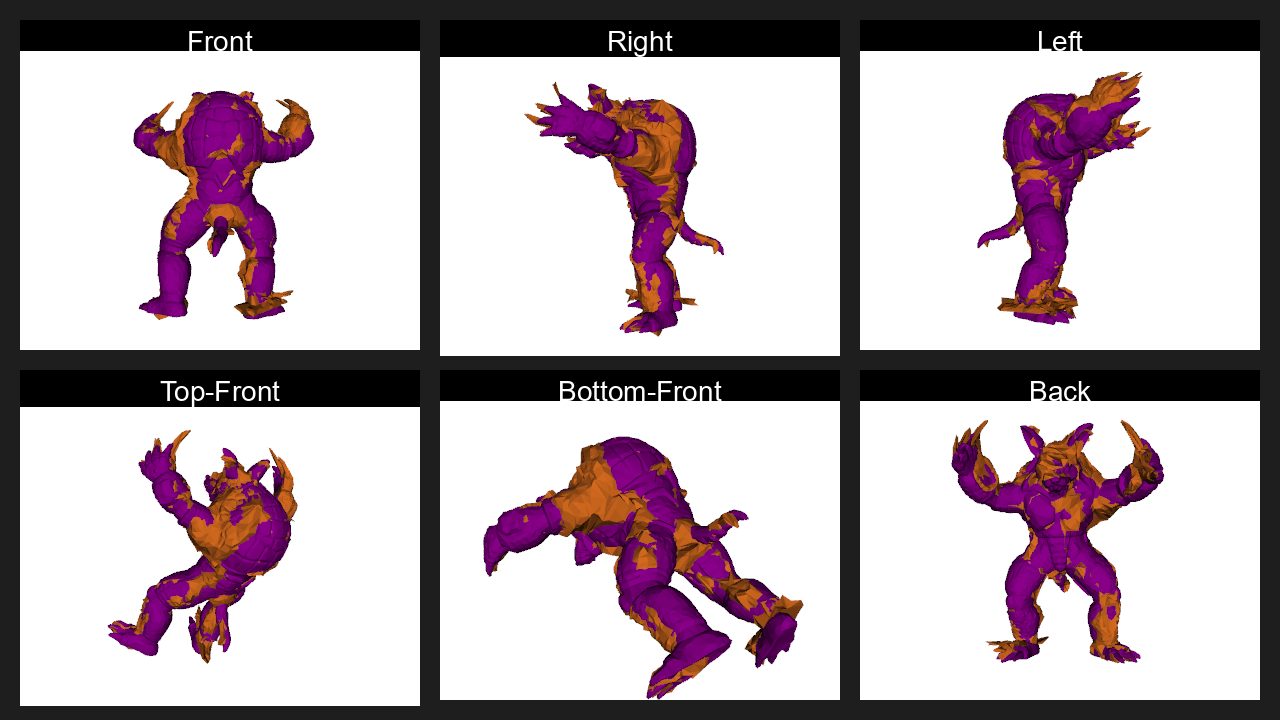

In [24]:
plot_superimposed(mesh11, TriMesh(final_target, mesh11.faces),
         cmap_p=np.tile(np.arange(len(id_lock)),2), point_size=0.01,
         colormap='jet')